# 6. Neural Network Regression

Let's now build a regression model using a neural network.

### Load the modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import h5py
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Check whether GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load dataset

In [3]:
# Read in dataset
devon_cornwall = pd.read_csv('./data/dandc_crime_and_demographics.csv')
# Drop LSOA code - we will add this back in later for mapping
devon_cornwall = devon_cornwall.drop('lsoa_code', axis=1)
# Make data float type
devon_cornwall = devon_cornwall.astype(float)

In [4]:
devon_cornwall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Columns: 271 entries, antisocial to outdoors_score
dtypes: float64(271)
memory usage: 2.1 MB


## Total crime
Let's first build a random forest regression model for predicting total crime.

### Divide into features (X) and labels (y)
We will split into features (X) and labels (y) and convert these from pandas dataframes to NumPy arrays. These are simpler to refer to by row/column index numbers, which we will use for sklearn's k-fold method.

In [5]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['crime_total'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'total'

### Scale the data

Now we will write a function for scaling the input data from 0 to 1.

In [6]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

### Build model based on a neural network

Let's build a sequential neural network model.

In [7]:
# Define function to train and apply regularised neural network
def neural_net(X,y):
    
    # Define save checkpoint callback (only save if new best validation results)
    checkpoint_cb = keras.callbacks.ModelCheckpoint('model_checkpoint.h5',
                                                save_best_only=True)
    
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)
        
    # Set up lists to hold history for each k-fold run
    histories = []
    r2_results = []
    # Set up dataframe to hold actual and predicted values
    pred_df = pd.DataFrame()
    # Set up splits
    number_of_splits = 10
    seed = 42
    kf = KFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    kf.get_n_splits(X, y)
    # Loop through the k-fold splits
    k_fold_count = 1
    for train_index, test_index in kf.split(X, y):
    
        print(f"\nFold number {k_fold_count}")
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Scale X data
        X_train_sc, X_test_sc = scale_data(X_train, X_test) 
        # Set up and fit model
        

        model = Sequential()
        model.add(Dense(1024, input_dim=X_train_sc.shape[1], activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01), 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
        history = model.fit(X_train_sc,
                            y_train,validation_data=(X_test_sc,y_test),
                            verbose=0,epochs=1000, 
                            batch_size=32,
                            callbacks=[checkpoint_cb, early_stopping_cb])
        
        histories.append(history)
        
        # Predict test set labels
        predictions = model.predict(X_test_sc)
        
        y_pred_test = []
        for prediction in predictions:
            for item in prediction:
                y_pred_test.append(item)
        
        # Add actual and predicted values to dataframe
        d = {'actual': y_test, 'pred': y_pred_test, 'k': k_fold_count}
        df = pd.DataFrame(data=d)
        pred_df = pd.concat([pred_df, df])
        
    
        k_fold_count +=1
        
        # Calculate R-squared and add to list
        r2 = r2_score(y_test, y_pred_test)
        r2_results.append(r2)
        
    # Calculate mean R-squared
    mean_r2 = np.mean(r2_results)
        
    return histories, pred_df, mean_r2

In [8]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [9]:
# Define function for plotting RMSE
def plot_RMSE(histories_and_pred):
    for history in histories_and_pred[0]:
        plt.plot(history.history['root_mean_squared_error'], label='train', color='green')
        plt.plot(history.history['val_root_mean_squared_error'], label='test', color='red')
        plt.ylabel('RMSE')
        plt.xlabel('Epochs')
    plt.legend(['train','test'])
    plt.show()

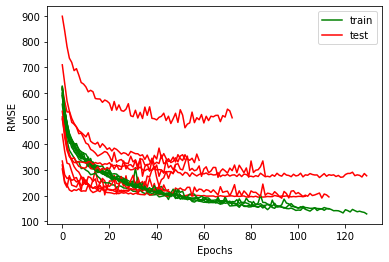

In [10]:
plot_RMSE(histories_and_pred)

In [11]:
# Define function for plotting mean RMSE
def plot_mean_RMSE(histories_and_pred):
    
    # Create lists of mean training and test RMSEs
    train_RMSE = []
    test_RMSE = []

    for history in histories_and_pred[0]:
        train_RMSE.append(history.history['root_mean_squared_error'])
        test_RMSE.append(history.history['val_root_mean_squared_error'])
    
    # Calculate mean training RMSE by epoch
    length = max(map(len, train_RMSE))
    train_RMSE=np.array([history+[None]*(length-len(history)) for history in train_RMSE], dtype=float)
    mean_train_RMSE = np.nanmean(train_RMSE, axis=0)
    
    # Calculate mean test RMSE by epoch
    length = max(map(len, test_RMSE))
    test_RMSE=np.array([history+[None]*(length-len(history)) for history in test_RMSE], dtype=float)
    mean_test_RMSE = np.nanmean(test_RMSE, axis=0)
    
    # Plot mean RMSE by epoch
    plt.plot(mean_train_RMSE, label='train', color='green')
    plt.plot(mean_test_RMSE, label='test', color='red')
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.legend(['train','test'])
    plt.show()

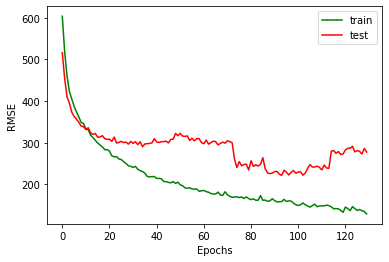

In [12]:
plot_mean_RMSE(histories_and_pred)

In [13]:
# Define function for calculating mean final RMSE
def mean_RMSE(histories_and_pred):
    training_error_results = []
    test_error_results = []
    for history in histories_and_pred[0]:
        error_train = history.history['root_mean_squared_error'][-1]
        error_test = history.history['val_root_mean_squared_error'][-1]
        training_error_results.append(error_train)
        test_error_results.append(error_test)
    mean_training = np.mean(training_error_results)
    mean_test = np.mean(test_error_results) 
    print('Mean training RMSE: ',mean_training)
    print('Mean test RMSE: ',mean_test)

In [14]:
mean_RMSE(histories_and_pred)

Mean training RMSE:  175.48600158691406
Mean test RMSE:  291.78163452148436


In [15]:
# Loot at mean test R-squared
histories_and_pred[2]

0.7362585732697943

### Plotting actual and predicted values

In [16]:
# Define function to plot predicted and actual values
def plot_actual_predicted(histories_and_pred):
    groups = histories_and_pred[1].groupby('k')
    
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.actual, group.pred, marker='.', linestyle='', ms=8, label=name)
    ax.legend(title = 'K fold')
    
    plt.xlabel('y actual')
    plt.ylabel('y predicted')
    plt.grid(True)

    plot = plt.show()
    
    return plot

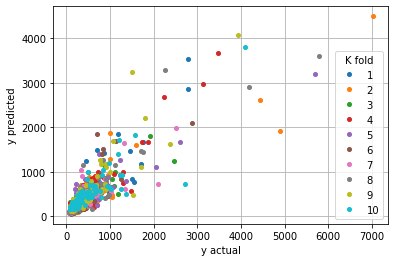

In [17]:
plot_actual_predicted(histories_and_pred)

## Antisocial behaviour

In [18]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['antisocial'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'antisocial'

In [19]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


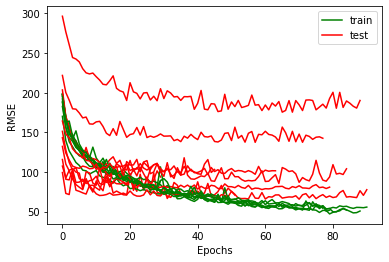

In [20]:
# Plot RMSE
plot_RMSE(histories_and_pred)

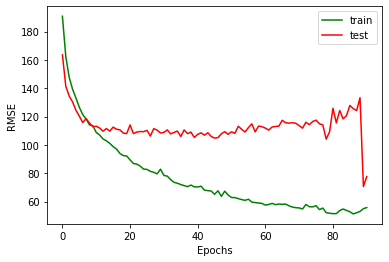

In [21]:
plot_mean_RMSE(histories_and_pred)

In [22]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  61.94490280151367
Mean test RMSE:  106.79108276367188


In [23]:
# Loot at mean test R-squared
histories_and_pred[2]

0.6990816127791158

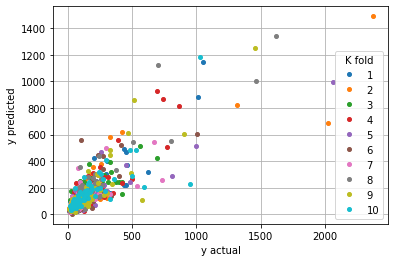

In [24]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Bike theft

In [25]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['bike_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'bike_theft'

In [26]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


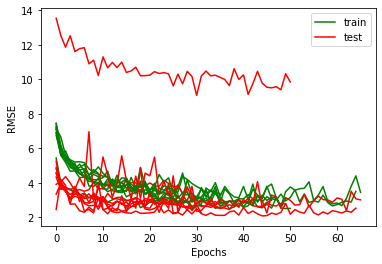

In [27]:
# Plot RMSE
plot_RMSE(histories_and_pred)

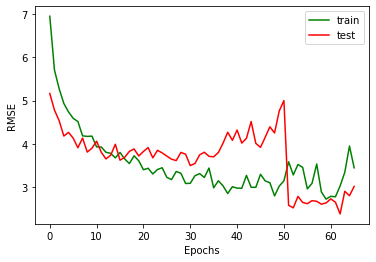

In [28]:
plot_mean_RMSE(histories_and_pred)

In [29]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  3.1285505533218383
Mean test RMSE:  3.672110843658447


In [30]:
# Loot at mean test R-squared
histories_and_pred[2]

0.6978999980967262

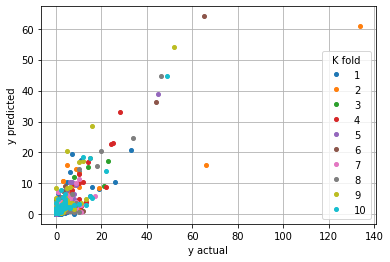

In [31]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Burglary

In [32]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['burglary'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'burglary'

In [33]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


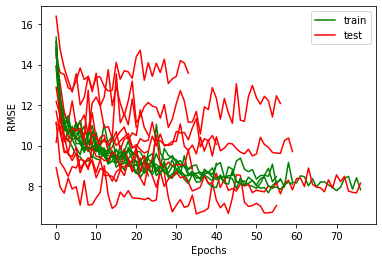

In [34]:
# Plot RMSE
plot_RMSE(histories_and_pred)

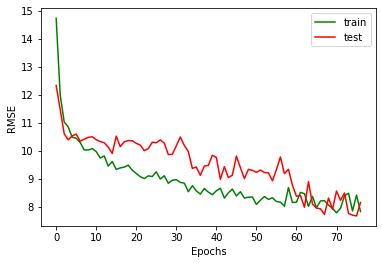

In [35]:
plot_mean_RMSE(histories_and_pred)

In [36]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  8.68433837890625
Mean test RMSE:  9.935730457305908


In [37]:
# Loot at mean test R-squared
histories_and_pred[2]

0.6063670597514483

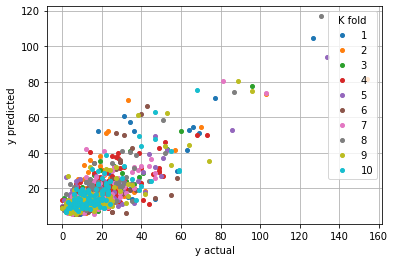

In [38]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Criminal damage and arson

In [39]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['damage_arson'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'damage_arson'

In [40]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


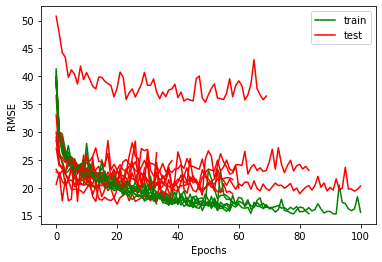

In [41]:
# Plot RMSE
plot_RMSE(histories_and_pred)

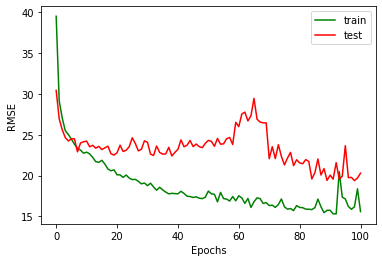

In [42]:
plot_mean_RMSE(histories_and_pred)

In [43]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  16.675168895721434
Mean test RMSE:  22.85546760559082


In [44]:
# Loot at mean test R-squared
histories_and_pred[2]

0.7130972947878796

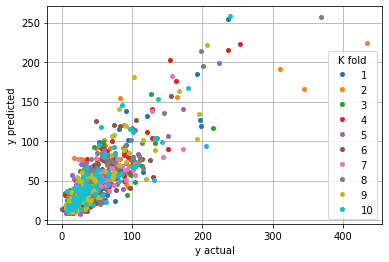

In [45]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Drugs

In [46]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['drugs'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'drugs'

In [47]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


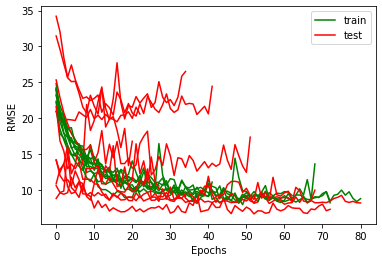

In [48]:
# Plot RMSE
plot_RMSE(histories_and_pred)

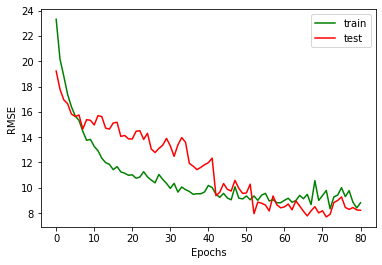

In [49]:
plot_mean_RMSE(histories_and_pred)

In [50]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  10.089202308654786
Mean test RMSE:  15.018998146057129


In [51]:
# Loot at mean test R-squared
histories_and_pred[2]

0.6268707925903254

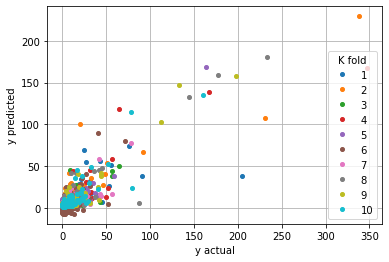

In [52]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Other crime

In [53]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'other_crime'

In [54]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


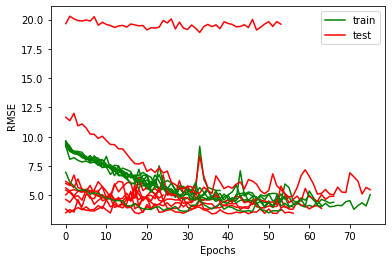

In [55]:
# Plot RMSE
plot_RMSE(histories_and_pred)

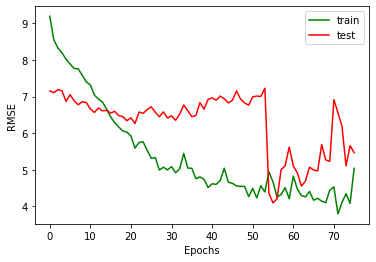

In [56]:
plot_mean_RMSE(histories_and_pred)

In [57]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  4.804717230796814
Mean test RMSE:  6.046467876434326


In [58]:
# Loot at mean test R-squared
histories_and_pred[2]

0.5303828586539037

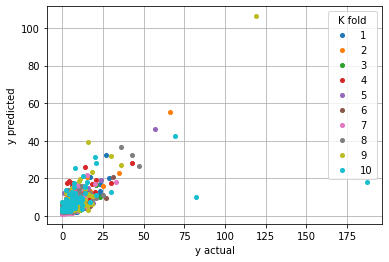

In [59]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Other theft

In [60]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'other_theft'

In [61]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


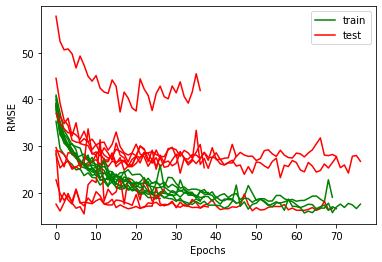

In [62]:
# Plot RMSE
plot_RMSE(histories_and_pred)

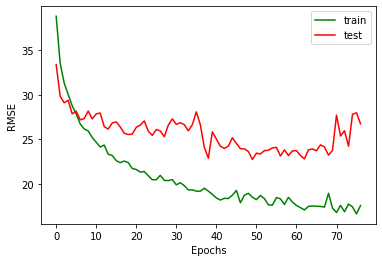

In [63]:
plot_mean_RMSE(histories_and_pred)

In [64]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  18.8465669631958
Mean test RMSE:  26.05889301300049


In [65]:
# Loot at mean test R-squared
histories_and_pred[2]

0.6002669127966043

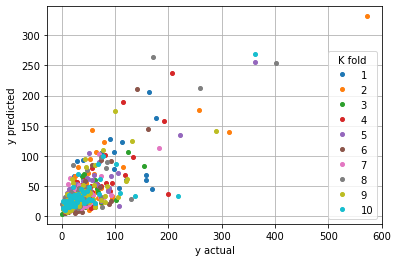

In [66]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Possession of weapons

In [67]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['possession_weapons'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'possession_weapons'

In [68]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


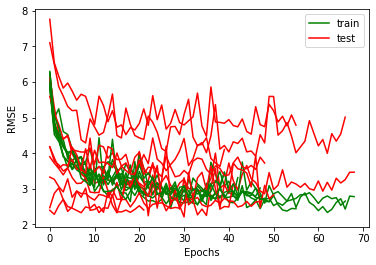

In [69]:
# Plot RMSE
plot_RMSE(histories_and_pred)

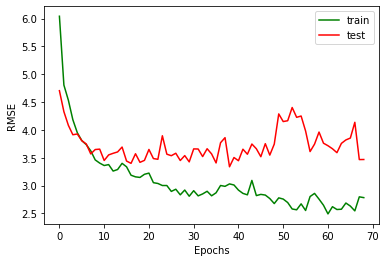

In [70]:
plot_mean_RMSE(histories_and_pred)

In [71]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  2.8767724514007567
Mean test RMSE:  3.5582387924194334


In [72]:
# Loot at mean test R-squared
histories_and_pred[2]

0.614773544297204

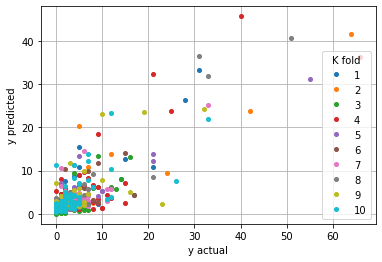

In [73]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Public order offences

In [74]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['public_order'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'public_order'

In [75]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


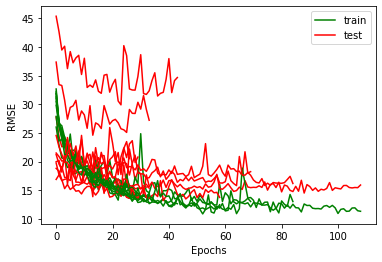

In [76]:
# Plot RMSE
plot_RMSE(histories_and_pred)

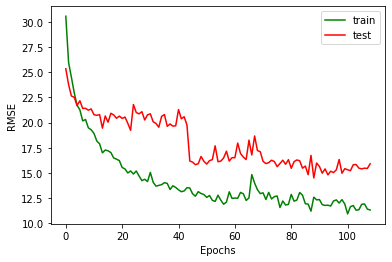

In [77]:
plot_mean_RMSE(histories_and_pred)

In [78]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  13.220158290863036
Mean test RMSE:  19.839401149749754


In [79]:
# Loot at mean test R-squared
histories_and_pred[2]

0.6521620081848942

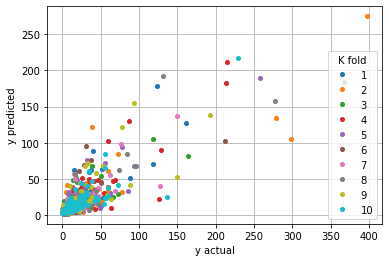

In [80]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Robbery

In [81]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['robbery'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'robbery'

In [82]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


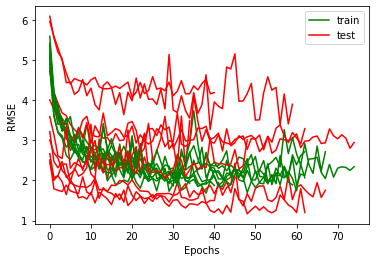

In [83]:
# Plot RMSE
plot_RMSE(histories_and_pred)

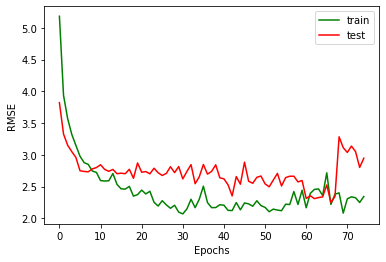

In [84]:
plot_mean_RMSE(histories_and_pred)

In [85]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  2.236375153064728
Mean test RMSE:  2.8394465684890746


In [86]:
# Loot at mean test R-squared
histories_and_pred[2]

0.7405949376402549

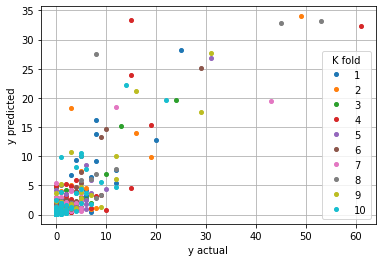

In [87]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Shoplifting

In [88]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['shoplifting'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'shoplifting'

In [89]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


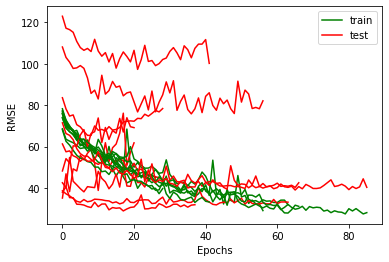

In [90]:
# Plot RMSE
plot_RMSE(histories_and_pred)

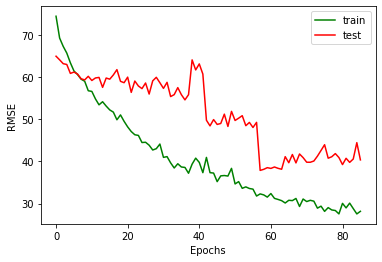

In [91]:
plot_mean_RMSE(histories_and_pred)

In [92]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  37.28283271789551
Mean test RMSE:  58.33194236755371


In [93]:
# Loot at mean test R-squared
histories_and_pred[2]

0.4281214206371116

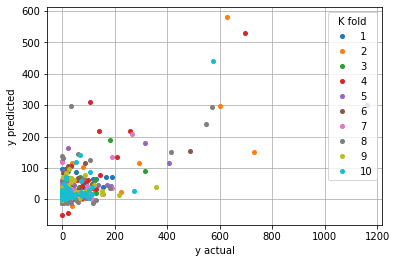

In [94]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Theft from the person

In [95]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['theft_person'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'theft_person'

In [96]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


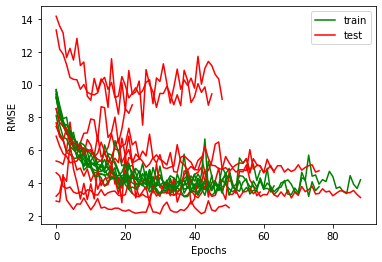

In [97]:
# Plot RMSE
plot_RMSE(histories_and_pred)

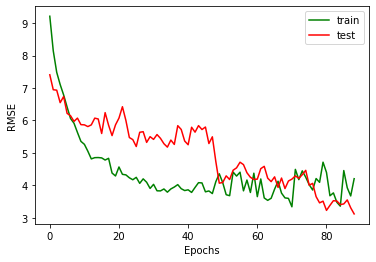

In [98]:
plot_mean_RMSE(histories_and_pred)

In [99]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  3.9704323053359984
Mean test RMSE:  5.536508679389954


In [100]:
# Loot at mean test R-squared
histories_and_pred[2]

0.6302198357362874

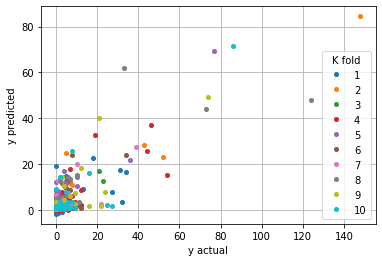

In [101]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Vehicle crime

In [102]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['vehicle_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'vehicle_crime'

In [103]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


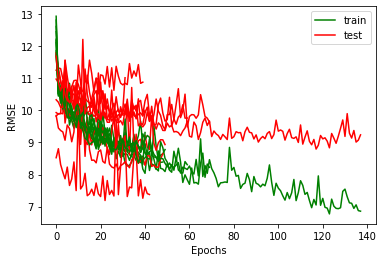

In [104]:
# Plot RMSE
plot_RMSE(histories_and_pred)

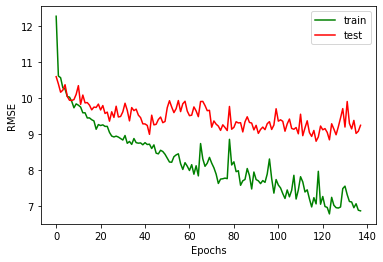

In [105]:
plot_mean_RMSE(histories_and_pred)

In [106]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  8.557319116592407
Mean test RMSE:  9.567267322540284


In [107]:
# Loot at mean test R-squared
histories_and_pred[2]

0.430540519980762

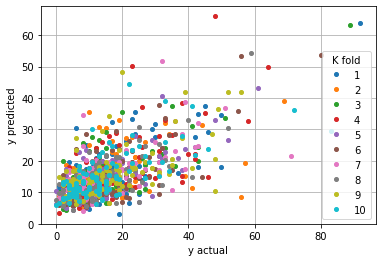

In [108]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)

## Violence and sexual offences

In [109]:
# Separate features from labels
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['violence_sexual'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

# Set name to be used for saved model
crime_type = 'violence_sexual'

In [110]:
histories_and_pred = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


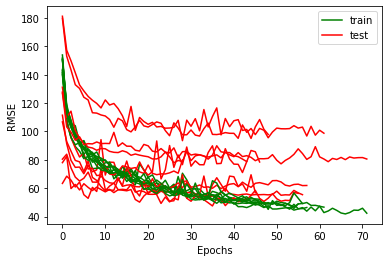

In [111]:
# Plot RMSE
plot_RMSE(histories_and_pred)

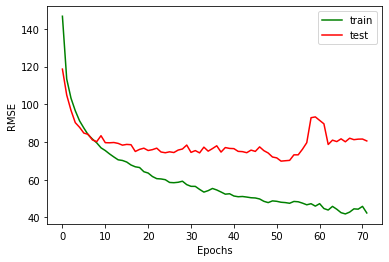

In [112]:
plot_mean_RMSE(histories_and_pred)

In [113]:
# Calculate mean final RMSE
mean_RMSE(histories_and_pred)

Mean training RMSE:  48.68551063537598
Mean test RMSE:  74.47356071472169


In [114]:
# Loot at mean test R-squared
histories_and_pred[2]

0.7448722271942719

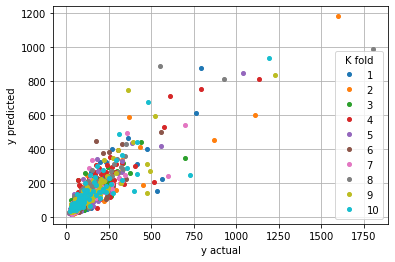

In [115]:
# Plot actual against predicted values
plot_actual_predicted(histories_and_pred)